In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from torch import nn
import torch.nn.functional as F

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F


class face_keypoints_network(nn.Module):
    
    def __init__(self):
        super(face_keypoints_network, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding = 1)
        self.conv5 = nn.Conv2d(128, 256, 3, padding = 1)
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(256 * 7 * 7, 2048)
        self.fc2 = nn.Linear(2048, 600)
        self.fc3 = nn.Linear(600, 136)
        
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 112
        x = self.pool(F.relu(self.conv2(x))) # 56
        x = self.pool(F.relu(self.conv3(x))) # 28
        x = self.pool(F.relu(self.conv4(x))) # 14
        x = self.pool(F.relu(self.conv5(x))) # 7
        
        x = x.view(-1, 256 * 7 * 7)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x


In [11]:
final_model = face_keypoints_network()
final_model.load_state_dict(torch.load('TrainedModels/model_499.pth', map_location='cpu'))
final_model.eval()

face_keypoints_network(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=600, bias=True)
  (fc3): Linear(in_features=600, out_features=136, bias=True)
  (dropout): Dropout(p=0.3)
)

In [12]:
test_image = cv2.imread('face.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
face_cascade = cv2.CascadeClassifier('/home/avinash/UIUC/CS543/face_filters/face_detection/assets/haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(test_image, 1.2, 2)

In [13]:
image_copy = np.copy(test_image)
images, keypoints = [], []
pad = 50    # margin outside detected face boundary
img_h, img_w = image_copy.shape[0], image_copy.shape[1]

# loop over the detected faces 
for (x, y, w, h) in faces:
    # 1. Select the region of interest that is the face in the image 
    roi = image_copy[max(0, y-pad): min(y+h+pad, img_h), max(0, x-pad): min(x+w+pad, img_w)]

    ## 2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi = (roi/255.).astype(np.float32)

    ## 3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    try:
        roi = cv2.resize(roi, (224, 224))
    except:
        pass
    ## 4. Append the resulting face into images array
    images.append(roi)
    
    ## 5. Convert the image into grayscale
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    
    ## 6. Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    if len(roi.shape) == 2:
        roi = np.expand_dims(roi, axis=0)
    else:
        roi = np.rollaxis(roi, 2, 0)
    
    ## 7. Make it a batch of length 1
    roi = np.expand_dims(roi, axis=0)
    
    ## 8. Convert the face region image into a torch tensor 
    roi = torch.from_numpy(roi).type(torch.FloatTensor)
    
    ## 9. Pass the image through the final model network
    results = final_model.forward(roi)
    
    ## 10. Reshape the keypoints output into 2 columns & put it in keypoints array
    results = results.view(results.size()[0], 68, -1).cpu()
    
    ## 11. Move the keypoints to cpu & de-normalize the values
    pred = results[0].cpu().data
    pred = pred.numpy()
    pred = pred * 50 + 100

    keypoints.append(pred)


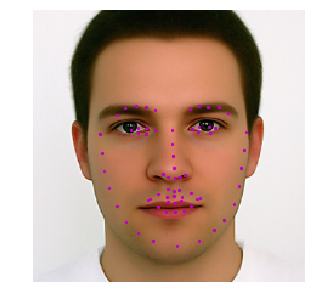

In [14]:
def visualize_output(faces, test_outputs):  
    for i, face in enumerate(faces):
        plt.figure(figsize=(5, 5))
        plt.imshow(face)
        plt.scatter(test_outputs[i][:, 0], test_outputs[i][:, 1], s=20, marker='.', c='m')
        plt.axis('off')

    plt.show()


visualize_output(images, keypoints)